In [1]:
import pybaseball as pyb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

# Release Point Difference

릴리스 포인트(Release Point) = 투수가 공을 던지는 순간의 위치

### **투수의 구종별 릴리스 포인트의 차이가 작다면, 타자들을 더 잘 속일 수 있을까?** 

투수의 목적은 타자를 속이는 것이다. 타자를 속이기 위해 다양한 구종을 던지는데, 예를 들어 포심패스트볼과 커브볼은 스핀축이 비슷하지만 각각 백스핀과 탑스핀의 회전을 하기 때문에 무브먼트가 정반대로 형성된다. 슬라이더의 경우 자이로 스핀이 주를 이루어 스핀 효율이 낮은 편이고, 이에 따라 전체적인 무브먼트도 작고 횡의 무브먼트가 있는 구종이다. 이렇듯이 구종별 구속과 무브먼트 차이에 의해 타자는 속게 된다. 

그렇다면 타자는 투수가 던지는 공의 위치, 릴리스 포인트를 보고 구별할 수 있을까? 이를 확인하기 위해, 투수별 릴리스 포인트 차이가 헛스윙율(Whiff %) 수치와 상관 관계가 있는지 분석해보았다. 또한, 릴리스 포인트의 차이가 타구의 결과(뜬공, 땅볼)에 영향을 미치는지 확인해보았다. 구종은 포심과 커브볼, 포심과 슬라이더 두가지 구종 조합에 대한 릴리스 포인트 차이를 계산하였다.

21시즌 MLB statcast 데이터를 활용하였다.

### **- [포심 + 커브](#fc)**
### **- [포심 + 슬라이더](#fs)**

----

# Data Importing

In [2]:
mlb_21 = pyb.statcast('2021-04-01', '2021-10-03')

This is a large query, it may take a moment to complete


100%|██████████| 186/186 [03:05<00:00,  1.00it/s]


<a id="fc"></a>
# 1. 포심 + 커브

In [3]:
# 21 시즌에 300개 이상의 투구를 던진 투수들

pitch_count =mlb_21.groupby(['player_name']).agg({
    'pitch_type': 'count',
}).reset_index().rename(columns={'pitch_type': 'total_count'}).sort_values(by='total_count', ascending=False)
over_300 = np.array(pitch_count[pitch_count['total_count']>300]['player_name'])

In [4]:
# 투수들의 구종별 퍼센트 계산

over_300_pitcher = mlb_21[mlb_21['player_name'].isin(over_300)]
over_300_pitcher = pd.merge(over_300_pitcher, pitch_count, on='player_name') 
type_count = over_300_pitcher.groupby(['player_name', 'pitch_name']).agg({
    'total_count': 'mean',
    'pitch_type': 'count'
}).reset_index().rename(columns={'pitch_type': 'count'})
type_count['perc'] = round((type_count['count']/type_count['total_count']),2)

In [5]:
# 커브볼의 비중이 20% 이상이고, 포심의 비중이 40% 이상인 투수들

curveballer = np.array(type_count[(type_count['pitch_name']=='Curveball') & (type_count['perc']>0.2)]['player_name'])
fourseamer = np.array(type_count[(type_count['pitch_name']=='4-Seam Fastball') & (type_count['perc']>0.4)]['player_name'])
ff_cb = over_300_pitcher[over_300_pitcher['player_name'].isin(curveballer) & over_300_pitcher['player_name'].isin(fourseamer)]
ff_cb_data = ff_cb[(ff_cb['pitch_name']=='4-Seam Fastball') | (ff_cb['pitch_name']=='Curveball')]
ff_cb_pitcher_list = ff_cb_data['player_name'].unique()

In [6]:
# 투수별 포심과 커브볼의 릴리스 포인트 차이 계산

player_diff=pd.DataFrame()
for i in ff_cb_pitcher_list:
    player_data = ff_cb[ff_cb['player_name']==i]
    diff_calc = player_data.groupby(['pitch_name']).agg({
        'pitch_type': 'count',
        'release_pos_x': 'mean',
        'release_pos_z': 'mean'
    }).reset_index().rename(columns={'pitch_type': 'count'})
    diff_calc['diff_x'] = diff_calc['release_pos_x'].diff()
    diff_calc['diff_z'] = diff_calc['release_pos_z'].diff()
    diff_calc['diff'] = np.sqrt(diff_calc['diff_x']**2 + diff_calc['diff_z']**2)
    diff = {'player_name': [i], 'diff': [diff_calc['diff'].sum()]}
    diff_df = pd.DataFrame(data=diff)
    player_diff = pd.concat([player_diff, diff_df])
ff_cb_data = pd.merge(ff_cb_data, player_diff, on='player_name')

In [7]:
# 포심과 커브볼의 헛스윙율, 땅볼비율, 뜬공비율 계산

swing = ['hit_into_play', 'foul', 'swinging_strike', 'foul_tip', 'swinging_strike_blocked']
miss = ['swinging_strike', 'foul_tip', 'swinging_strike_blocked']
ff_cb_data['miss'] = np.where(ff_cb_data['description'].isin(miss), 1, 0)
ff_cb_data['swing'] = np.where(ff_cb_data['description'].isin(swing), 1, 0)
ff_cb_data['ground_ball'] = np.where(ff_cb_data['bb_type']=='ground_ball',1,0)
ff_cb_data['fly_ball'] = np.where(ff_cb_data['bb_type']=='fly_ball',1,0)
ff_cb_data['line_drive'] = np.where(ff_cb_data['bb_type']=='line_drive',1,0)
ff_cb_data['popup'] = np.where(ff_cb_data['bb_type']=='popup',1,0)

final_ff_cb = ff_cb_data.groupby(['player_name','pitch_name']).agg({
    'pitch_type': 'count', 
    'miss': 'sum',
    'swing':'sum',
    'bb_type': 'count',
    'ground_ball': 'sum',
    'fly_ball': 'sum',
    'line_drive': 'sum',
    'diff': 'mean'}).reset_index()
final_ff_cb['swing_per'] = round((final_ff_cb['swing']/final_ff_cb['pitch_type'])*100,2)
final_ff_cb['swstr_per'] = round((final_ff_cb['miss']/final_ff_cb['pitch_type'])*100,2)
final_ff_cb['whiff_per'] = round((final_ff_cb['miss']/final_ff_cb['swing'])*100,2)
final_ff_cb['ground_per'] = round((final_ff_cb['ground_ball']/final_ff_cb['bb_type'])*100,2)
final_ff_cb['fly_per'] = round((final_ff_cb['fly_ball']/final_ff_cb['bb_type'])*100,2)

In [8]:
# 포심과 커브볼 데이터 분리

final_ff = final_ff_cb[final_ff_cb['pitch_name']=='4-Seam Fastball']
final_cb = final_ff_cb[final_ff_cb['pitch_name']=='Curveball']

In [9]:
final_ff.head()

,player_name,pitch_name,pitch_type,miss,swing,bb_type,ground_ball,fly_ball,line_drive,diff,swing_per,swstr_per,whiff_per,ground_per,fly_per
0,"Anderson, Ian",4-Seam Fastball,1025,98,456,170,90,34,36,0.352719,44.49,9.56,21.49,52.94,20.00
2,"Bednar, David",4-Seam Fastball,521,87,312,83,26,26,23,0.349490,59.88,16.70,27.88,31.33,31.33
4,"De Jong, Chase",4-Seam Fastball,379,32,192,73,16,32,22,0.957398,50.66,8.44,16.67,21.92,43.84
6,"Diplán, Marcos",4-Seam Fastball,319,37,150,51,21,15,8,0.498480,47.02,11.60,24.67,41.18,29.41
8,"Dunn, Justin",4-Seam Fastball,450,44,211,69,22,28,11,0.387797,46.89,9.78,20.85,31.88,40.58


In [10]:
final_cb.head()

,player_name,pitch_name,pitch_type,miss,swing,bb_type,ground_ball,fly_ball,line_drive,diff,swing_per,swstr_per,whiff_per,ground_per,fly_per
1,"Anderson, Ian",Curveball,460,60,167,62,25,14,20,0.352719,36.30,13.04,35.93,40.32,22.58
3,"Bednar, David",Curveball,220,37,79,21,10,4,5,0.349490,35.91,16.82,46.84,47.62,19.05
5,"De Jong, Chase",Curveball,183,16,66,28,12,7,6,0.957398,36.07,8.74,24.24,42.86,25.00
7,"Diplán, Marcos",Curveball,139,11,55,26,10,8,7,0.498480,39.57,7.91,20.00,38.46,30.77
9,"Dunn, Justin",Curveball,280,35,119,37,12,15,5,0.387797,42.50,12.50,29.41,32.43,40.54


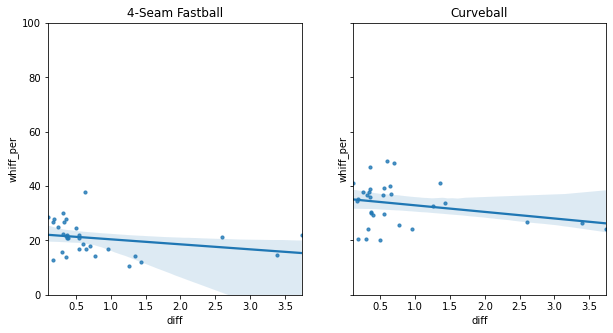

In [11]:
# Plotting

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
sns.regplot(x='diff', y='whiff_per', data=final_ff, ax=ax1, scatter_kws={'s':10})
ax1.set_ylim([0, 100])
ax1.set_title('4-Seam Fastball')
sns.regplot(x='diff', y='whiff_per', data=final_cb, ax=ax2, scatter_kws={'s':10})
ax2.set_title('Curveball')
plt.show()

In [12]:
# Linear Regression

import statsmodels.formula.api as smf

reg_1_1 = smf.ols(formula = 'whiff_per ~ diff', data=final_ff).fit()
reg_1_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              whiff_per   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     2.198
Date:                Mon, 24 Jan 2022   Prob (F-statistic):              0.149
Time:                        01:02:42   Log-Likelihood:                -98.938
No. Observations:                  31   AIC:                             201.9
Df Residuals:                      29   BIC:                             204.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.2515      1.470     15.140      0.000      19.246      25.257
diff          -1.8406      1.241     -1.483      0.149      -4.380       0.698
==============================================================================
Omnibus:                        2.582   Durbin-Watson:                   2.216
Prob(Omnibus):                  0.275   Jarque-Bera (JB):                1.561
Skew:                           0.533   Prob(JB):                        0.458
Kurtosis:                       3.270   Cond. No.                         2.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
reg_1_2 = smf.ols(formula = 'whiff_per ~ diff', data=final_cb).fit()
reg_1_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              whiff_per   R-squared:                       0.073
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     2.276
Date:                Mon, 24 Jan 2022   Prob (F-statistic):              0.142
Time:                        01:02:42   Log-Likelihood:                -106.92
No. Observations:                  31   AIC:                             217.8
Df Residuals:                      29   BIC:                             220.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     35.3464      1.901     18.591      0.000      31.458      39.235
diff          -2.4231      1.606     -1.509      0.142      -5.708       0.862
==============================================================================
Omnibus:                        0.043   Durbin-Watson:                   2.311
Prob(Omnibus):                  0.979   Jarque-Bera (JB):                0.140
Skew:                          -0.075   Prob(JB):                        0.932
Kurtosis:                       2.707   Cond. No.                         2.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

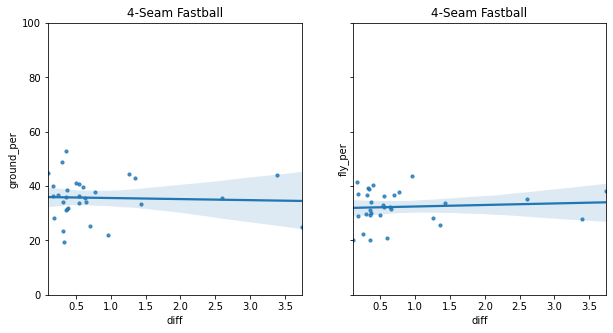

In [14]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
sns.regplot(x='diff', y='ground_per', data=final_ff, ax=ax1, scatter_kws={'s':10})
ax1.set_ylim([0, 100])
ax1.set_title('4-Seam Fastball')
sns.regplot(x='diff', y='fly_per', data=final_ff, ax=ax2, scatter_kws={'s':10})
ax2.set_title('4-Seam Fastball')
plt.show()

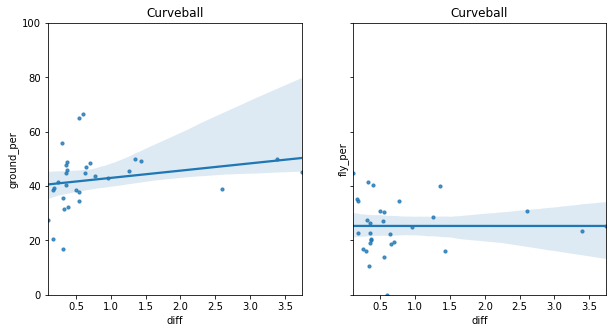

In [15]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
sns.regplot(x='diff', y='ground_per', data=final_cb, ax=ax1, scatter_kws={'s':10})
ax1.set_ylim([0, 100])
ax1.set_title('Curveball')
sns.regplot(x='diff', y='fly_per', data=final_cb, ax=ax2, scatter_kws={'s':10})
ax2.set_title('Curveball')
plt.show()

21시즌에 투구를 500개 이상 한 투수들 중 커브볼의 비중이 15% 이상이고, 포심의 비중이 40% 이상인 투수들의 데이터를 살펴보았다. 투수별 포심과 커브의 릴리스 포인트 차이를 계산하고, 이 차이가 투구에 어떤 영향을 미치는지 분석해보았다. 우선 릴리스 포인트 차이에 따른 헛스윙율(Whiff %) 차이가 있는지 확인해보았지만, 유의미한 차이를 발견하지 못하였다. 뜬공과 땅볼 비중 또한, 릴리스 포인트 차이에 따른 차이를 확인하기 어려웠다.

----

<a id="fs"></a>
# 2. 포심 + 슬라이더

In [16]:
# 슬라이더의 비중이 25% 이상이고, 포심의 비중이 40% 이상인 투수들

slider_ = np.array(type_count[(type_count['pitch_name']=='Slider') & (type_count['perc']>0.25)]['player_name'])
fourseamer = np.array(type_count[(type_count['pitch_name']=='4-Seam Fastball') & (type_count['perc']>0.4)]['player_name'])
ff_sl = over_300_pitcher[over_300_pitcher['player_name'].isin(slider_) & over_300_pitcher['player_name'].isin(fourseamer)]
ff_sl_data = ff_sl[(ff_sl['pitch_name']=='4-Seam Fastball') | (ff_sl['pitch_name']=='Slider')]
ff_sl_pitcher_list = ff_sl_data['player_name'].unique()

In [17]:
# 투수별 포심과 슬라이더의 릴리스 포인트 차이 계산

player_diff_2=pd.DataFrame()
for i in ff_sl_pitcher_list:
    player_data = ff_sl[ff_sl['player_name']==i]
    diff_calc = player_data.groupby(['pitch_name']).agg({
        'pitch_type': 'count',
        'release_pos_x': 'mean',
        'release_pos_z': 'mean'
    }).reset_index().rename(columns={'pitch_type': 'count'})
    diff_calc['diff_x'] = diff_calc['release_pos_x'].diff()
    diff_calc['diff_z'] = diff_calc['release_pos_z'].diff()
    diff_calc['diff'] = np.sqrt(diff_calc['diff_x']**2 + diff_calc['diff_z']**2)
    diff = {'player_name': [i], 'diff': [diff_calc['diff'].sum()]}
    diff_df = pd.DataFrame(data=diff)
    player_diff_2 = pd.concat([player_diff_2, diff_df])
ff_sl_data = pd.merge(ff_sl_data, player_diff_2, on='player_name')

In [18]:
# 포심과 슬라이더의 헛스윙율, 땅볼비율, 뜬공비율 계산

ff_sl_data['miss'] = np.where(ff_sl_data['description'].isin(miss), 1, 0)
ff_sl_data['swing'] = np.where(ff_sl_data['description'].isin(swing), 1, 0)
ff_sl_data['ground_ball'] = np.where(ff_sl_data['bb_type']=='ground_ball',1,0)
ff_sl_data['fly_ball'] = np.where(ff_sl_data['bb_type']=='fly_ball',1,0)
ff_sl_data['line_drive'] = np.where(ff_sl_data['bb_type']=='line_drive',1,0)
ff_sl_data['popup'] = np.where(ff_sl_data['bb_type']=='popup',1,0)

final_ff_sl = ff_sl_data.groupby(['player_name','pitch_name']).agg({
    'pitch_type': 'count', 
    'miss': 'sum',
    'swing':'sum',
    'bb_type': 'count',
    'ground_ball': 'sum',
    'fly_ball': 'sum',
    'line_drive': 'sum',
    'diff': 'mean'}).reset_index()
final_ff_sl['swstr_per'] = round((final_ff_sl['miss']/final_ff_sl['pitch_type'])*100,2)
final_ff_sl['whiff_per'] = round((final_ff_sl['miss']/final_ff_sl['swing'])*100,2)
final_ff_sl['ground_per'] = round((final_ff_sl['ground_ball']/final_ff_sl['bb_type'])*100,2)
final_ff_sl['fly_per'] = round((final_ff_sl['fly_ball']/final_ff_sl['bb_type'])*100,2)

In [19]:
# 포심과 슬라이더 데이터 분리

final_ff_2 = final_ff_sl[final_ff_sl['pitch_name']=='4-Seam Fastball']
final_sl = final_ff_sl[final_ff_sl['pitch_name']=='Slider']

In [20]:
final_ff_2.head()

,player_name,pitch_name,pitch_type,miss,swing,bb_type,ground_ball,fly_ball,line_drive,diff,swstr_per,whiff_per,ground_per,fly_per
0,"Abreu, Bryan",4-Seam Fastball,310,34,142,47,19,13,10,0.713912,10.97,23.94,40.43,27.66
2,"Allen, Logan",4-Seam Fastball,368,19,166,83,36,24,23,1.238340,5.16,11.45,43.37,28.92
4,"Almonte, Yency",4-Seam Fastball,395,18,165,70,33,19,12,1.257533,4.56,10.91,47.14,27.14
6,"Archer, Chris",4-Seam Fastball,147,9,57,19,5,9,5,0.574453,6.12,15.79,26.32,47.37
8,"Barlow, Joe",4-Seam Fastball,205,20,112,40,13,15,9,0.624584,9.76,17.86,32.50,37.50


In [21]:
final_sl.head()

,player_name,pitch_name,pitch_type,miss,swing,bb_type,ground_ball,fly_ball,line_drive,diff,swstr_per,whiff_per,ground_per,fly_per
1,"Abreu, Bryan",Slider,256,46,121,40,19,9,9,0.713912,17.97,38.02,47.50,22.50
3,"Allen, Logan",Slider,276,36,134,45,17,14,11,1.238340,13.04,26.87,37.78,31.11
5,"Almonte, Yency",Slider,357,63,152,46,14,11,16,1.257533,17.65,41.45,30.43,23.91
7,"Archer, Chris",Slider,138,28,71,24,6,7,8,0.574453,20.29,39.44,25.00,29.17
9,"Barlow, Joe",Slider,185,34,95,27,14,3,7,0.624584,18.38,35.79,51.85,11.11


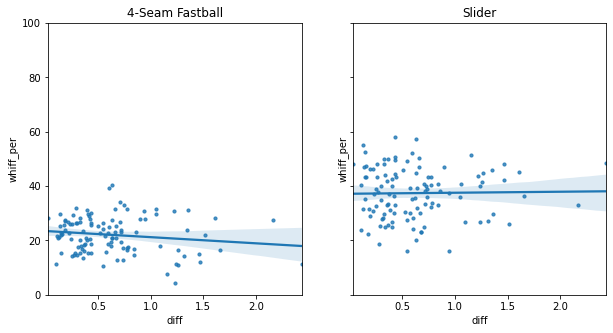

In [22]:
# Plotting

fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
sns.regplot(x='diff', y='whiff_per', data=final_ff_2, ax=ax1, scatter_kws={'s':10})
ax1.set_ylim([0, 100])
ax1.set_title('4-Seam Fastball')
sns.regplot(x='diff', y='whiff_per', data=final_sl, ax=ax2, scatter_kws={'s':10})
ax2.set_title('Slider')
plt.show()

In [23]:
# Linear Regression

reg_2_1 = smf.ols(formula = 'whiff_per ~ diff', data=final_ff_2).fit()
reg_2_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              whiff_per   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.498
Date:                Mon, 24 Jan 2022   Prob (F-statistic):              0.117
Time:                        01:02:46   Log-Likelihood:                -370.45
No. Observations:                 112   AIC:                             744.9
Df Residuals:                     110   BIC:                             750.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.4792      1.092     21.507      0.000      21.316      25.643
diff          -2.2697      1.436     -1.580      0.117      -5.116       0.576
==============================================================================
Omnibus:                        0.924   Durbin-Watson:                   1.966
Prob(Omnibus):                  0.630   Jarque-Bera (JB):                1.030
Skew:                           0.193   Prob(JB):                        0.597
Kurtosis:                       2.733   Cond. No.                         3.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
reg_2_2 = smf.ols(formula = 'whiff_per ~ diff', data=final_sl).fit()
reg_2_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              whiff_per   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.009
Method:                 Least Squares   F-statistic:                   0.03375
Date:                Mon, 24 Jan 2022   Prob (F-statistic):              0.855
Time:                        01:02:46   Log-Likelihood:                -408.63
No. Observations:                 112   AIC:                             821.3
Df Residuals:                     110   BIC:                             826.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     37.1789      1.535     24.220      0.000      34.137      40.221
diff           0.3710      2.019      0.184      0.855      -3.631       4.373
==============================================================================
Omnibus:                        3.661   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.160   Jarque-Bera (JB):                2.194
Skew:                          -0.089   Prob(JB):                        0.334
Kurtosis:                       2.338   Cond. No.                         3.29
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

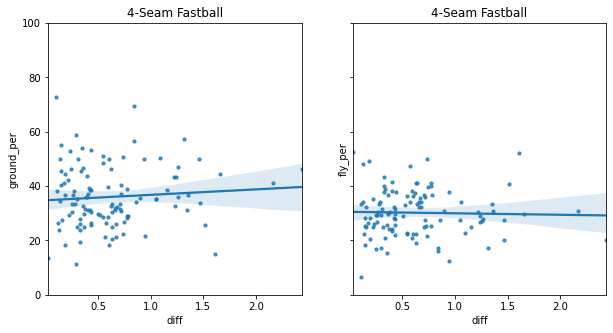

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
sns.regplot(x='diff', y='ground_per', data=final_ff_2, ax=ax1, scatter_kws={'s':10})
ax1.set_ylim([0, 100])
ax1.set_title('4-Seam Fastball')
sns.regplot(x='diff', y='fly_per', data=final_ff_2, ax=ax2, scatter_kws={'s':10})
ax2.set_title('4-Seam Fastball')
plt.show()

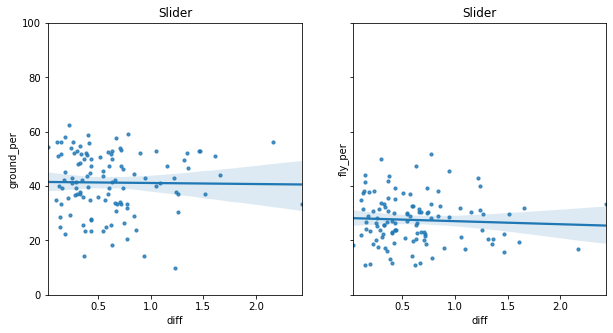

In [26]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(10,5))
sns.regplot(x='diff', y='ground_per', data=final_sl, ax=ax1, scatter_kws={'s':10})
ax1.set_ylim([0, 100])
ax1.set_title('Slider')
sns.regplot(x='diff', y='fly_per', data=final_sl, ax=ax2, scatter_kws={'s':10})
ax2.set_title('Slider')
plt.show()

21시즌에 투구를 500개 이상 한 투수들 중 슬라이더의 비중이 25% 이상이고, 포심의 비중이 40% 이상인 투수들의 데이터를 살펴보았다. 투수별 포심과 슬라이더의 릴리스 포인트 차이를 계산하고, 이 차이가 투구에 어떤 영향을 미치는지 분석해보았다. 포심+커브 조합과 마찬가지로 릴리스 포인트 차이에 따른 유의미한 차이를 확인하지 못했다.

----

# 결론

투수가 던지는 구종들의 릴리스 포인트가 차이가 난다면, 타자들이 구종을 예측하여 타구 결과에 영향이 미칠 것이라는 가정을 세웠었다. 하지만 이번 분석에서는 가정을 뒷받침할만한 근거를 발견하지 못하였다. 포심과 커브볼의 조합을 사용하는 투수들의 데이터와 포심과 슬라이더 조합을 사용하는 투수들의 데이터를 살펴보았을 때, 두 구종의 릴리스 포인트 차이가 크더라도 차이가 작은 데이터와 유의미한 차이를 나타내지 않았다. 실제로 타자들이 릴리스 포인트 차이를 통해 구종 예측이 안되는 것일 수도 있지만, 이번 분석이 가지는 문제점 때문이라고 생각할 수도 있다.
   
이번 분석의 문제점은 투수의 구종을 두가지로 제한했다는 점이다. 릴리스 포인트 거리 계산을 위해 한 투수당 두 개의 구종을 비교하였다. 최대한 구종 구사 비율이 높은 데이터(포심 40% 이상, 커브 20% 이상, 슬라이더 30% 이상)들을 추출하여 분석하기는 했지만, 대부분의 투수는 3~4개 이상의 구종을 구사하기 때문에 분석에 사용한 두 개의 구종이 투수의 타구 결과를 대표한다고 보기는 어렵다.
   
이 문제를 해결하기 위해서 추후에 기계 학습을 적용할 예정이다. 릴리스 포인트에 따라 투수들의 구종 예측 모델을 학습시킨다면, 모든 구종에 대한 결과를 확인할 수 있다. 각 투수마다 모델의 구종 예측 score와 투구 결과에 대한 분석을 수행한다면, 정말 릴리스 포인트 차이가 타구 결과에 영향을 미치는지 확인할 수 있을 것이다.